# Kaggle Prediction

## 1. Introduction

According to the World Health Organization (WHO) stroke is the 2nd leading cause of death globally, responsible for approximately 11% of total deaths.

This dataset is used to predict whether a patient is likely to get stroke based on the input parameters like gender, age, various diseases, and smoking status. Each row in the data provides relavant information about the patient.

#### Column Descriptions
1) id: unique identifier
2) gender: "Male", "Female" or "Other"
3) age: age of the patient
4) hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
5) heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
6) ever_married: "No" or "Yes"
7) work_type: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"
8) Residence_type: "Rural" or "Urban"
9) avg_glucose_level: average glucose level in blood
10) bmi: body mass index
11) smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"*
12) stroke: 1 if the patient had a stroke or 0 if not
*Note: "Unknown" in smoking_status means that the information is unavailable for this patient

### 1.1 Import Packages

In [1]:
#import basic packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#to split the datasets
from sklearn.model_selection import train_test_split

# feature engineering imputation
from feature_engine import imputation as mdi

# for one hot encoding with sklearn
from sklearn.preprocessing import OneHotEncoder

# for encoding with feature-engine
from feature_engine.encoding import OneHotEncoder as fe_OneHotEncoder
from feature_engine.encoding import OrdinalEncoder as fe_OrdinalEncoder


#univariate imputation
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer

#multivariate imputation
from sklearn.impute import KNNImputer

#user-interactive visulization with plotly
import plotly.express as px
import plotly.figure_factory as ff

# for Q-Q plots
import scipy.stats as stats

#outlier handeling with feature engine through discretisation
from feature_engine.discretisation import EqualWidthDiscretiser

#gaussian transformation
import feature_engine.transformation as vt

#read images
from PIL import Image

# the scaler - for standardisation
from sklearn.preprocessing import StandardScaler

### 1.2 Read Data

In [3]:
#Read data
df = pd.read_csv("Data/healthcare-dataset-stroke-data.csv")
print(f"Dimention of raw data is {df.shape}")


#Get rid of the 'id' column. In general, id column doesn't contribute to prediction.
#id column in this data has been masked by the author for data privacy.
#An alternative way is to replace index with id column. This preserves data information especially for time series data.
df.drop('id',inplace=True,axis=1)
print(f"Dimention of data after dropping the 'id' column is {df.shape}")
df.head(10)

Dimention of raw data is (5110, 12)
Dimention of data after dropping the 'id' column is (5110, 11)


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
5,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1
6,Male,74.0,1,1,Yes,Private,Rural,70.09,27.4,never smoked,1
7,Female,69.0,0,0,No,Private,Urban,94.39,22.8,never smoked,1
8,Female,59.0,0,0,Yes,Private,Rural,76.15,NaN,Unknown,1
9,Female,78.0,0,0,Yes,Private,Urban,58.57,24.2,Unknown,1


### 1.3 Summary Statistics

In [4]:
#Check datatypes 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB


In [5]:
#Summary statistics
df.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [6]:
#Check missing values
df.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [7]:
#Check the proportion of missing value in the 'bmi' column
bmi_na = df['bmi'].isna().sum()
bmi_all = df.shape[0]
print(f"The proportion of missing value in the bmi column is {round((bmi_na/bmi_all),3)*100}%.")

The proportion of missing value in the bmi column is 3.9%.


**Initial Insights from the Data**


*   Bmi column contains missing data: Approximately 201 data points are missing which equates to 3.9% of the data

*   Categorical features are: Gender, Ever_married,Work_type,Residence_type,smoking_status

*   Binary Numerical Features: hypertension,heart_disease,stroke

*   Continuous Numerical Features: age,avg_glucose_level,bmi

*   Categorical variables must be encoded for ML methods later on

* Outliers in Continuous Numerical Features must be processed, this can be done by considering different methods  


### 1.4 Correlation Plot


<AxesSubplot:>

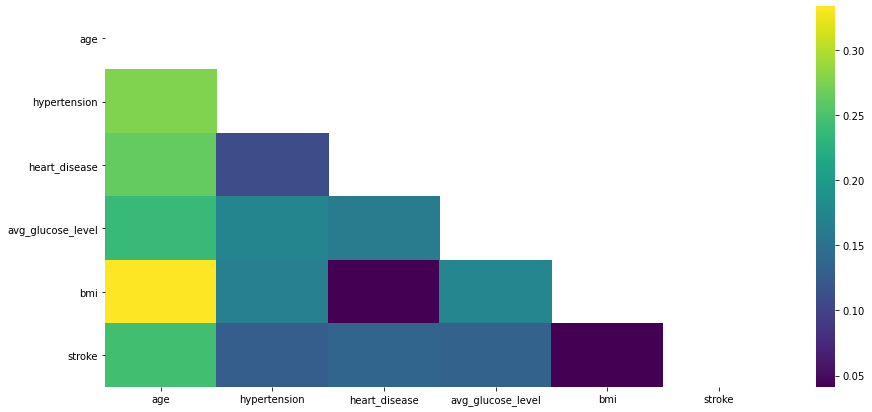

In [8]:
plt.figure(figsize=(15,7))

# Compute correlations
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(corr,mask=mask,cmap='viridis',annot=False)

**Insights from Correlation Plot**


*   None of the variables are strongly correlated to stroke
*   No two variables are strongly correlated, which indicates there are no redundant variables in the dataset


## 2. Feature Engineering

### 2.1 Split into train and test 
Splitting dataset into train and test at the beginning is a good practice. It prevents leaking information and overfitting.

In [9]:
#Split into traing and testing set
X = df.drop(['stroke'],axis=1)
y = df['stroke']

X_train,X_test,y_train,y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=0,
    shuffle=True
)

X_train.shape, X_test.shape

((4088, 10), (1022, 10))

In [10]:
#check there are stroke cases in both train and test set
print(f"The percentage of stroke cases in train set is {round(y_train.value_counts()[1]/len(y_train),3)*100}%")
print(f"The percentage of stroke cases in test set is {round(y_test.value_counts()[1]/len(y_test),3)*100}%")

The percentage of stroke cases in train set is 4.8%
The percentage of stroke cases in test set is 5.3%


### 2.2 Categorical Variable Encoding 

Replacing the categorical strings by numerical representation, so that it can be used in ML models

1) One Hot Encoding

2) Integer Encoding

In this projet, we'll use One Hot Encoding. 
Interger Encoding doesn't capture any information about the categorical lables, which leads difficulty to present visualizations in later stage.

In [296]:
ohe_enc = fe_OneHotEncoder(
    top_categories=None,
    #variables= [...],  # Feature-Engine's one hot encoder also selects all categorical variables automatically
    drop_last=True)  # to return k-1, false to return k


ohe_enc.fit(X_train)

ohe_enc.variables_

['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

In [297]:
X_train = ohe_enc.transform(X_train)

X_train.head()
X_train.shape

(4088, 16)

We can see there are 6 more columns introduced by One Hot Encoding

In [298]:
X_test = ohe_enc.transform(X_test)

X_test.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_Female,gender_Male,ever_married_Yes,work_type_Private,work_type_Self-employed,work_type_children,work_type_Govt_job,Residence_type_Rural,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
42,82.0,0,1,144.90,26.4,0,1,1,1,0,0,0,0,0,0,1
380,4.0,0,0,106.22,16.7,0,1,0,0,0,1,0,1,0,0,0
3524,58.0,0,0,79.95,25.9,0,1,1,1,0,0,0,0,0,1,0
352,20.0,0,0,96.57,34.1,1,0,0,1,0,0,0,1,0,1,0
4927,10.0,0,0,69.84,13.7,1,0,0,0,0,1,0,1,0,0,0


### 2.3 Handeling Outliers

The following are some outlier handing methods:

1) Trimming - Removing
2) Missing data - Treat outliers as missing data and perform missing data imputation
3) Discretisation - Put outliers into lower/upper bins
4) Capping - replace by maximum/minimum allowed values

#### 2.3.1 Handling outliers in bmi

Rule of thumb:

1) Normal distribution - Values outside mean + or - 3 * standard deviation are outliers
2) Skewed distribution - Values outside [25<sup>th</sup>  Quantile - IQR * 1.5, 75<sup>th</sup> Quantile + IQR * 1.5] are outliers, * 3 for extreme outliers

In [299]:
#function to create histogram, Q-Q plot and boxplot


def diagnostic_plots(df, variable):
    # function takes a dataframe (df) and
    # the variable of interest as arguments

    # define figure size
    plt.figure(figsize=(16, 4))

    # histogram
    plt.subplot(1, 3, 1)
    sns.distplot(df[variable], bins=30)
    plt.title('Histogram')

    # Q-Q plot
    plt.subplot(1, 3, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.ylabel('Variable quantiles')

    # boxplot
    plt.subplot(1, 3, 3)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')

    plt.show()

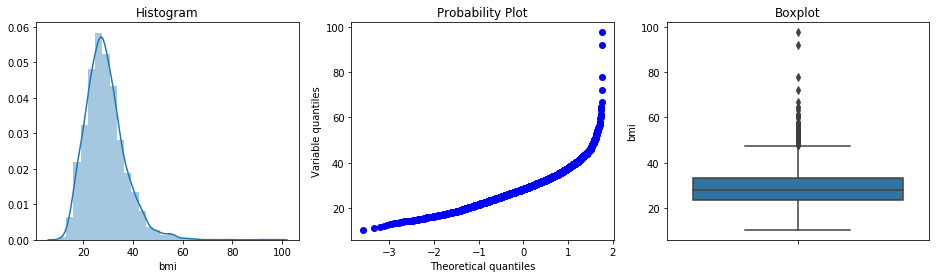

In [300]:
# let's find outliers in numerical columns - bmi

diagnostic_plots(X_train, 'bmi')


We'll use replace outliers with maximum allowed values with **Capping** method. Replacing ourliers with median/mean will lose the represetation of the population with large BMI in our model.

Note: When doing capping, we tend to cap values both in train and test set. It is important to remember that the capping values MUST be derived from the train set. And then use those same values to cap the variables in the test set.

In [301]:
def find_skewed_boundaries(df, variable, distance):

    # Let's calculate the boundaries outside which sit the outliers
    # for skewed distributions

    # distance passed as an argument, gives us the option to
    # estimate 1.5 times or 3 times the IQR to calculate
    # the boundaries.

    IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)

    upper_boundary = round(df[variable].quantile(0.75) + (IQR * distance),2)

    return upper_boundary

**Which Sensitivity to Chose?**

In [302]:
ulbmi1=find_skewed_boundaries(df,'bmi',1.5)  
bmi_outlier=0
for a in df['bmi'].to_numpy():
  if a > ulbmi1:
    bmi_outlier +=1
ulbmi2=find_skewed_boundaries(df,'bmi',3)  
bmi_outlier1=0
for a in df['bmi'].to_numpy():
  if a > ulbmi2:
    bmi_outlier1 +=1

print('There are {o} outliers when we chose a sensitivity of 1.5, the upperbound is given by {u}'.format(o=bmi_outlier,u=ulbmi1)) 
print('There are {o} outliers when we chose a sensitivity of 3, the upperbound is given by {u}'.format(o=bmi_outlier1,u=ulbmi2)) 

There are 110 outliers when we chose a sensitivity of 1.5, the upperbound is given by 47.5
There are 8 outliers when we chose a sensitivity of 3, the upperbound is given by 61.9


In order to decide which sensitvity we must first look at the different ranges which can be used to define BMI.

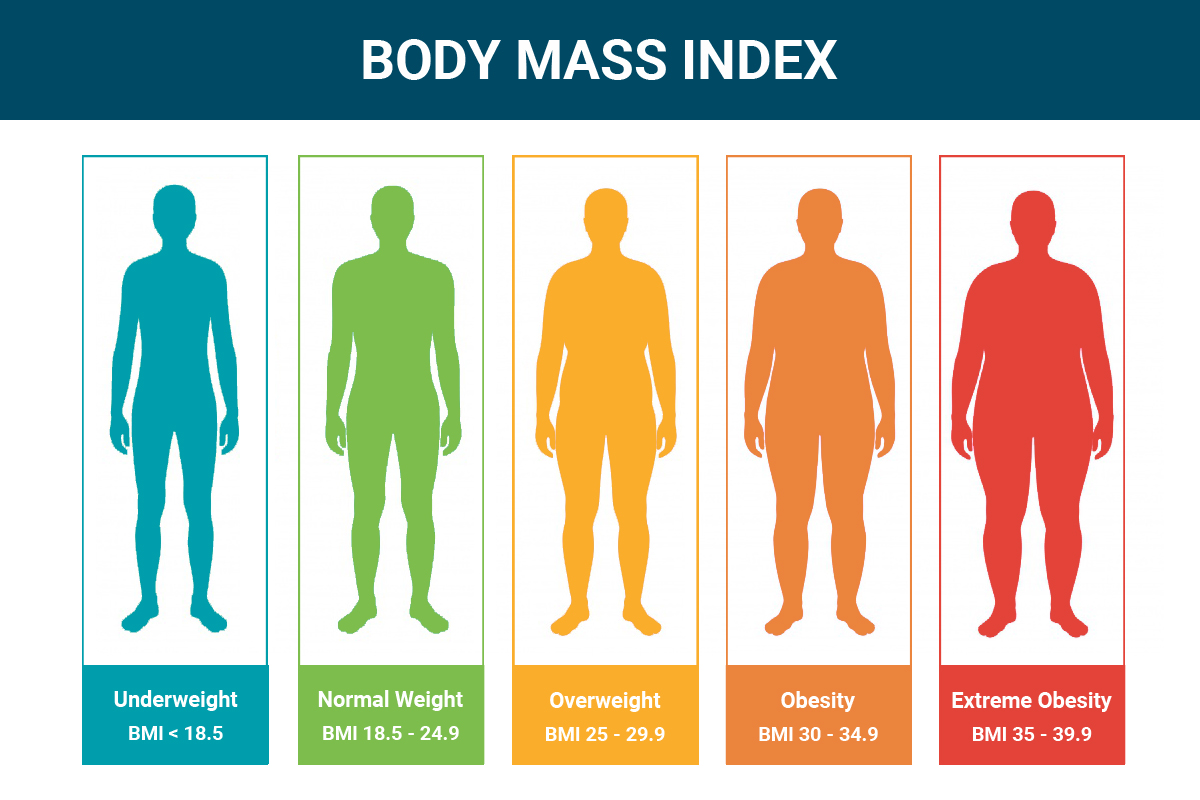

In [303]:
image = Image.open("body-mass-index-bmi-chart.jpg")
image

As there are extreme outliers in the right tail, extreme obesity need to be considered in our cases.

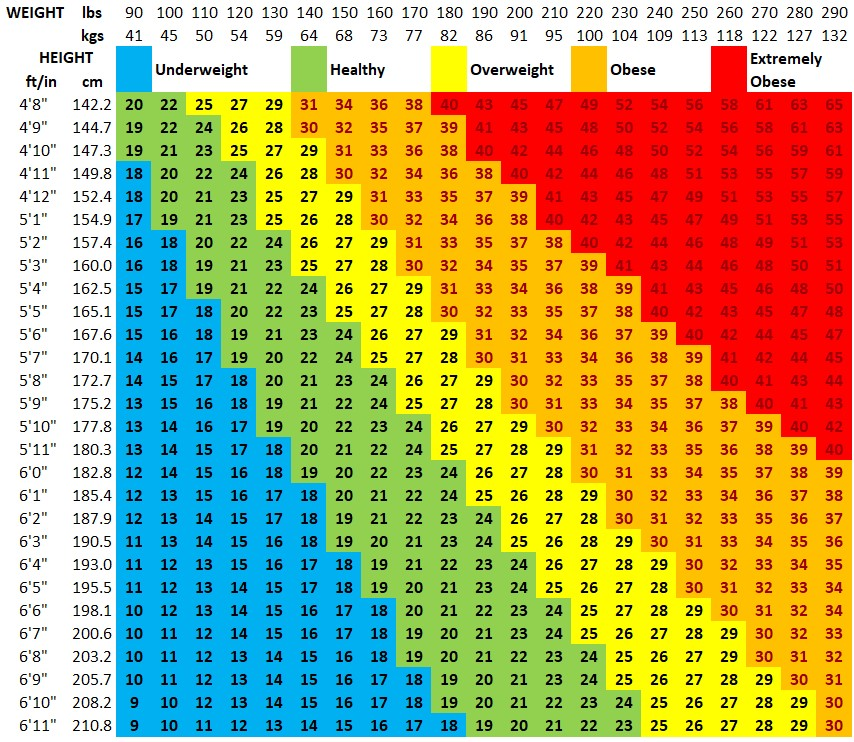

In [304]:
image = Image.open("bmi-chart.png")
image

* Using the chart above it makes sense to use a sensitivity of 1.5
* As BMI values approach 47+ for lower heights this causes a massive increase in weight leading upwards of 240lbs which equavalents to about 130kg
* Such a weight would be absurd for someone of such small heights therefore a cut off of 47 using a sensitivity of 1.5 would be an optimal option


In [305]:
#find limits for bmi
#put distance as 3 to replace only extreme outliers 
bmi_upper_limit = find_skewed_boundaries(X_train, 'bmi', 1.5)
bmi_upper_limit

47.5

In [306]:
# Now let's replace the extreme outliers by the maximum limit
# Note: extreme outliers in the test set are replaced by bmi_upper_limit found in training set 
# to prevent overfitting/data leaking
X_train['bmi']= np.where(X_train['bmi'] > bmi_upper_limit, bmi_upper_limit, X_train['bmi'])
X_test['bmi']= np.where(X_test['bmi'] > bmi_upper_limit, bmi_upper_limit, X_test['bmi'])

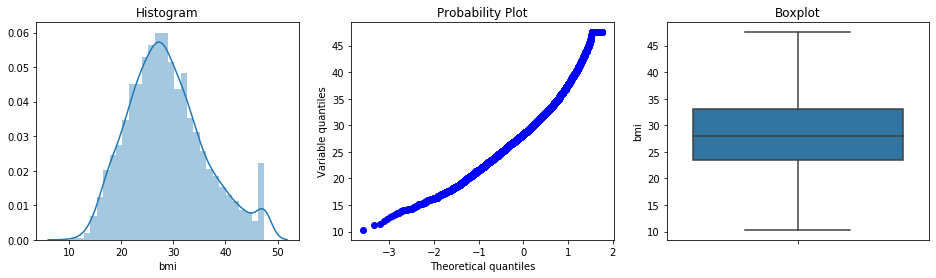

In [307]:
# let's explore outliers in the capped dataset

diagnostic_plots(X_train, 'bmi')


After replacing outliers with the upperlimit defined previously, we can there are no more outliers.

#### 2.4.2 Handling outliers for avg_glucose_level
Discretisation is the process of transforming continuous variables into discrete variables by creating a set of continuous intervals that span the range of the variable's values. Discretisation is also called binning, where bin is an alternative name for interval.

Discretisation helps handle outliers by placing these values into the lower or higher intervals, together with the remaining inlier values of the distribution. Thus, these outlier observations no longer differ from the rest of the values at the tails of the distribution, as they are now all together in the same interval / bucket. In addition, by creating appropriate bins or intervals, discretisation can help spread the values of a skewed variable across a set of bins with equal number of observations.

1) Equal width discretisation
2) Equal frequency discretisation
3) K-means discretisation
4) Discretisation using decision trees (Supervised)
5) Domain knowledge discretisation

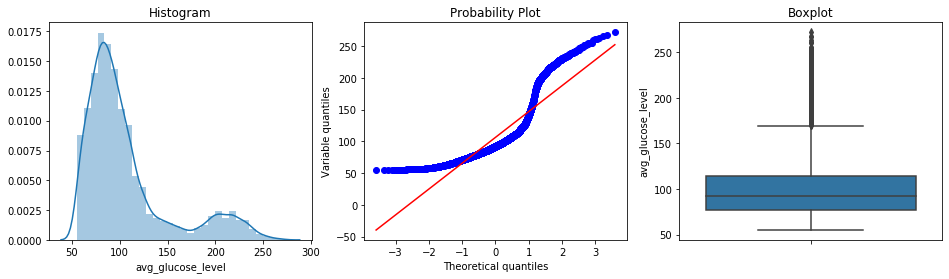

In [308]:
# let's find outliers in numerical columns - avg_glucose_level

diagnostic_plots(X_train, 'avg_glucose_level')

We can see there is a dense group of outliers at the right-hand tile. We want this group to be represeted in the general population.

In our case, we apply domain knowledge and use the standard glucose levels advised by doctors.

* less than 90 : Low
* 90 - 160: Normal
* 161 - 230: High
* 231 - 500: Very High

In [309]:
#apply to train data
X_train['avg_glucose_level_ranked'] = pd.cut(X_train['avg_glucose_level'], bins = [0,90,160,230,500], labels = ['Low', 'Normal', 'High', 'Very High'])

#apply to test data
X_test['avg_glucose_level_ranked'] = pd.cut(X_test['avg_glucose_level'], bins = [0,90,160,230,500], labels = ['Low', 'Normal', 'High', 'Very High'])

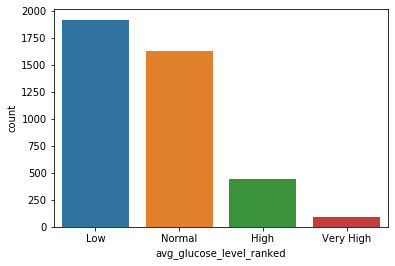

In [310]:
sns.countplot(x='avg_glucose_level_ranked',data=X_train)

The grouped avg_glucose_level is now categorical variable, which also needs to be encoded as numericl representation.

As the grouped avg_glucose_level has a ranked ordering, we'll apply **Ordinal Encoding**.

In [311]:
# set up the encoder
encoder = fe_OrdinalEncoder(encoding_method='ordered', variables=['avg_glucose_level_ranked'])

# fit the encoder
encoder.fit(X_train, y_train)

# transform the data
X_train= encoder.transform(X_train)
X_test= encoder.transform(X_test)

In [312]:
X_train[['avg_glucose_level','avg_glucose_level_ranked']].head(20)

,avg_glucose_level,avg_glucose_level_ranked
3029,67.29,0
2277,83.53,0
3002,65.16,0
246,78.80,0
2825,58.65,0
1969,90.36,1
4465,78.79,0
3138,81.26,0
5044,81.10,0
2818,82.41,0


From the table above, we can see the column avg_glucose_level_ranked has ranking order matching to actual value group. Recall:
* less than 90 : Low
* 90 - 160: Normal
* 161 - 230: High
* 231 - 500: Very High

### 2.4 Deal with missing value
The following are some methods for imput missing data

Feature Engineering: https://deloittedevelopment.udemy.com/course/feature-engineering-for-machine-learning/learn/lecture/24165994#overview

#### Numerical Variables
1) Mean/Median/Mode imputation
2) Arbitrary imputation
3) End of tail imputation

#### Categorical Variables
1) Frequent category imputation
2) Adding a "missing" category

#### Both
1) Drop missing data
2) Adding a "missing" category
3) Random sample imputation

#### Multivarite Imputation
1) KNN/Regression/Other ML models imputation
2) MICE - Multivarite imputation of chained equations
3) missForest imputation - Extends MICE using random forests






In [313]:
#Check the number of missing values in each column
df.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [314]:
#Check the proportion of missing value in the 'bmi' column
bmi_na = df['bmi'].isna().sum()
bmi_all = df.shape[0]
print(f"The proportion of missing value in the bmi column is {round((bmi_na/bmi_all),3)*100}%.")


The proportion of missing value in the bmi column is 3.9%.


#### 2.4.1 Univariate Imputation

Use Mean/Median imputation and grid seach to find the imputation method that gives the best ROC-AUC

In [315]:
pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('svc',SVC())
])

param_grid = {
    'imputer__strategy': ['mean', 'median'],
}

grid_search_uni = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1, scoring='roc_auc')

# and now we train over all the possible combinations of the parameters above
grid_search_uni.fit(X_train, y_train)

# and we print the best score over the train set
print(("Best ROC-AUC score from grid search in training set: %.3f"
       % grid_search_uni.score(X_train, y_train)))

Best ROC-AUC score from grid search in training set: 0.968


In [316]:
# and finally let's check the performance over the test set
print(("Best ROC-AUC score from grid search in tesing set: %.3f"
       % grid_search_uni.score(X_test, y_test)))

Best ROC-AUC score from grid search in tesing set: 0.620


In [317]:
# and find the best fit parameters like this
grid_search_uni.best_params_

{'imputer__strategy': 'median'}

We can see median imputaion outperforms mean imputation. We'll look into more details later through investigating the distribution plot.

#### 2.4.2 Multivariate Imputation

Use KNN imputation and grid search to find imputation parameters that gives the best ROC-AUC

In [318]:
pipe = Pipeline(steps=[
    ('imputer', KNNImputer(
        n_neighbors=5,
        weights='distance',
        add_indicator=False)),
    
    ('scaler', StandardScaler()),
    ('svc',SVC()),
])

In [319]:
# now we create the grid with all the parameters that we would like to test

param_grid = {
    'imputer__n_neighbors': [3,5,10],
    'imputer__weights': ['uniform', 'distance'],
}

grid_search_multi = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1, scoring='roc_auc')

# cv=3 is the cross-validation
# no_jobs =-1 indicates to use all available cpus
# scoring='r2' indicates to evaluate using the r squared

# for more details in the grid parameters visit:
#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

In [320]:
# and now we train over all the possible combinations 
# of the parameters above
grid_search_multi.fit(X_train, y_train)

# and we print the best score over the train set
print(("Best ROC-AUC score from grid search in training set: %.3f"
       % grid_search_multi.score(X_train, y_train)))

Best ROC-AUC score from grid search in training set: 0.966


In [321]:
# let's check the performance over the test set
print(("Best ROC-AUC score from grid search in test set: %.3f"
       % grid_search_multi.score(X_test, y_test)))

Best ROC-AUC score from grid search in test set: 0.624


In [322]:
# and find the best parameters

grid_search_multi.best_params_

{'imputer__n_neighbors': 5, 'imputer__weights': 'uniform'}

In summary, univariate imputation (median) and multivariate imputation (KNN) return approximately the same performance, with training ROC-AUC score around 97%.

Thus, we don't need to add the additional complexity of training models to impute NA. We'll choose univariate imputation.



##### 2.4.3 Compare distibution of bmi before and after missing data imputation

Note: The imputation values (that is the median/mean) should be calculated using the training set, and the same value should be used to impute the test set. This is to avoid overfitting.

When learn a model on traing set and deploy it on a test set, you are implicitly assume that both sets are drawn from the same distribution.

In [323]:
# Let's explore the missing data in the train set.
# The percentage of NA should be fairly similar to those observed in the whole dataset, which was 3.9%

X_train.isnull().mean()

age                               0.000000
hypertension                      0.000000
heart_disease                     0.000000
avg_glucose_level                 0.000000
bmi                               0.039139
gender_Female                     0.000000
gender_Male                       0.000000
ever_married_Yes                  0.000000
work_type_Private                 0.000000
work_type_Self-employed           0.000000
work_type_children                0.000000
work_type_Govt_job                0.000000
Residence_type_Rural              0.000000
smoking_status_formerly smoked    0.000000
smoking_status_never smoked       0.000000
smoking_status_smokes             0.000000
avg_glucose_level_ranked          0.000000
dtype: float64

In [324]:
# Calculate the median and mean bmi, for comparison

median = X_train.bmi.median()
print(f"Median calculated from the training set is {median}")

# Calculate the mean 
mean = np.round(X_train.bmi.mean(),1)
print(f"Mean calculated from the training set is {mean}")


Median calculated from the training set is 28.0
Mean calculated from the training set is 28.7


In [325]:
# Create a new variable with the missing values replaced
# using the function we created above.

# First, replace with the median.
X_train['bmi_median'] = X_train['bmi'].fillna(median)

# Now replace with the mean.
X_train['bmi_mean'] = X_train['bmi'].fillna(mean)

#Check the data and we can see the second row missing bmi was replace by median and mean 
X_train[['bmi','bmi_mean','bmi_median']].tail(15)

,bmi,bmi_mean,bmi_median
1701,13.4,13.4,13.4
2897,NaN,28.7,28.0
2222,14.2,14.2,14.2
2135,26.1,26.1,26.1
2599,23.0,23.0,23.0
705,33.8,33.8,33.8
3468,31.2,31.2,31.2
4373,16.8,16.8,16.8
1033,30.4,30.4,30.4
4859,34.4,34.4,34.4


In [326]:
# We can see a change in the variance after mean / median imputation.
# median imputation has variable variace slightly closer to the original variance

print('Original variable variance: ', round(X_train['bmi'].var(),3))
print('Variance after median imputation: ', round(X_train['bmi_median'].var(),3))
print('Variance after mean imputation: ', round(X_train['bmi_mean'].var(),3))

Original variable variance:  54.726
Variance after median imputation:  52.604
Variance after mean imputation:  52.584


In [327]:
#introduce a new visualization package plotly: https://plotly.com/python/getting-started/
#it's a user interactive plotting library that supports over 40 unique chart types covering a wide range of 
#statistical, financial, geographic, scientific, and 3-dimensional use-cases.

# check distibution for bmi before imputation


fig = px.histogram(X_train, x='bmi', marginal="box",
                   hover_data=X_train)
fig.update_layout(title_text='Box Plot and distribution of bmi before Imputation')
fig.show()

In [328]:
# check distribution of bmi after mean/median imputation

x2 = X_train['bmi_median']
x3 = X_train['bmi_mean']

hist_data = [x2, x3]

group_labels = ['Median Imputation', 'Mean Imputation']
colors = ['#835AF1', '#37AA9C']

# Create distplot with curve_type set to 'normal'
fig = ff.create_distplot(hist_data, group_labels, show_hist=False, colors=colors)

# Add title
fig.update_layout(title_text='Compare bmi Distribution after Mean and Median Imputation')
fig.show()

In [329]:
#drop bmi and bmi_mean column
X_train.drop(['bmi','bmi_mean'],axis=1,inplace=True)

#use median from training set to replace missing values in test set to prevent overfitting
X_test['bmi_median']=X_test['bmi'].fillna(median)

#drop bmi column
X_test.drop(['bmi'],axis=1,inplace=True)

print(X_train.shape)
print(X_test.shape)


(4088, 17)
(1022, 17)


In [330]:
X_train.isna().sum()

age                               0
hypertension                      0
heart_disease                     0
avg_glucose_level                 0
gender_Female                     0
gender_Male                       0
ever_married_Yes                  0
work_type_Private                 0
work_type_Self-employed           0
work_type_children                0
work_type_Govt_job                0
Residence_type_Rural              0
smoking_status_formerly smoked    0
smoking_status_never smoked       0
smoking_status_smokes             0
avg_glucose_level_ranked          0
bmi_median                        0
dtype: int64

In [331]:
X_test.isna().sum()

age                               0
hypertension                      0
heart_disease                     0
avg_glucose_level                 0
gender_Female                     0
gender_Male                       0
ever_married_Yes                  0
work_type_Private                 0
work_type_Self-employed           0
work_type_children                0
work_type_Govt_job                0
Residence_type_Rural              0
smoking_status_formerly smoked    0
smoking_status_never smoked       0
smoking_status_smokes             0
avg_glucose_level_ranked          0
bmi_median                        0
dtype: int64

Now both train and test set has bmi_median column with no missing values.

##### 2.4.4 Investigate Unknow lable in smoking_status

In [332]:
#Check the number of Unknow in smoking_status
smoke_groups = df.groupby(['smoking_status']).size().reset_index(name='Count')
print(smoke_groups)
smoke_unkown = smoke_groups[smoke_groups['smoking_status']=='Unknown']['Count'][0]
smoke_all = df.shape[0]
print(f"The proportion of Unkown in the smoke_status column is {round(smoke_unkown/smoke_all,3)*100}%")


    smoking_status  Count
0          Unknown   1544
1  formerly smoked    885
2     never smoked   1892
3           smokes    789
The proportion of Unkown in the smoke_status column is 30.2%


Previous missing data in the smoking_status has already been handeled by the method 'Missing category Imputation'.
Specifically, a new lable 'Unknow'was created to replace missing data.

This is the most widely used method of missing data imputation for categorical variables. It can capture the importance of "missingness" if there is one. The method is better be applied to category with large proportion of missing values, which in our case 30.2%. Thus, it won't introduce unbalanced lables for the category.

### 2.5 Gaussian Transformation (Learn and trail, we didn't apply it to our data)

Some machine learning models like linear and logistic regression assume that the variables are normally distributed. Often, variables are not normally distributed, but, transforming the variables to map their distribution to a Gaussian distribution may, and often does, boost the performance of the machine learning algorithm.

The most commonly used methods to transform variables are:

1) Logarithmic transformation - np.log(X)
2) Reciprocal transformation - 1 / X
3) Square root transformation - X**(1/2)
4) Exponential transformation (more general, you can use any exponent)
5) Box-Cox transformation
6) Yeo-Johnson transformation

Briefly, the Box-Cox transformation is an adaptation of the exponential transformation, scanning through various exponents, and it already represents the untransformed variable, as well as the log transformed, reciprocal, square and cube root transformed. So by doing Box-Cox transformation, in a way, we are evaluating all the other transformations and choosing the best one. Box-Cox can only be applied to positive variables.

Yeo-Johnson is a modification of the Box-Cox transformation so that it can be applied as well to non-positive variables

We'll  use Box-Cox transformation given reasons above.

For more details please check: https://www.statisticshowto.com/probability-and-statistics/normal-distributions/box-cox-transformation/

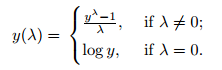

In [333]:
jpgfile = Image.open("boxcox-formula-1.png")
jpgfile

In [334]:
bct = vt.BoxCoxTransformer(variables = ['bmi_median','age'])
bct.fit(X_train)

BoxCoxTransformer(variables=['bmi_median', 'age'])

In [335]:
# check best lambda selected for the BoxCox transformation. 
# note: lambas don't equal to 0, the best tranformation function for the two variables are not log transformation

bct.lambda_dict_

{'bmi_median': 0.24213897845997268, 'age': 0.8422819006044889}

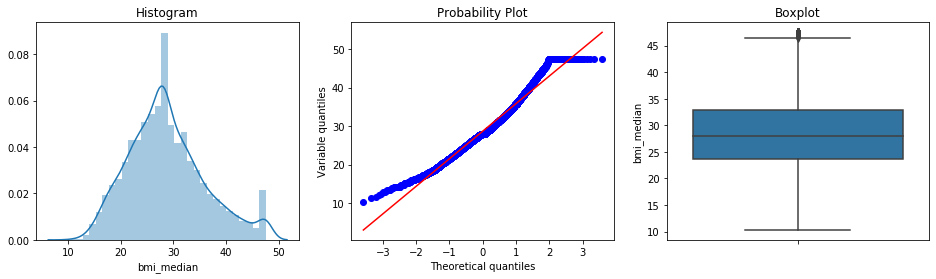

In [336]:
#Compare before and after transformation for bmi
diagnostic_plots(X_train, 'bmi_median')

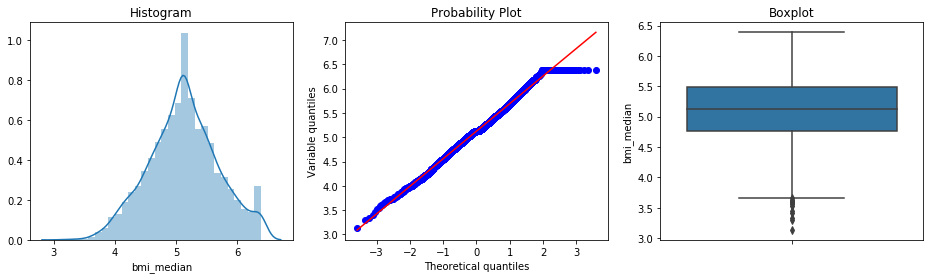

In [337]:
X_train_tf = bct.transform(X_train)
diagnostic_plots(X_train_tf, 'bmi_median')

#### We can see from the plot that after transformation, there are more outliers been introduced in the left tail. This is not what we want from variable transformation. We won't apply variable transformation to bmi.

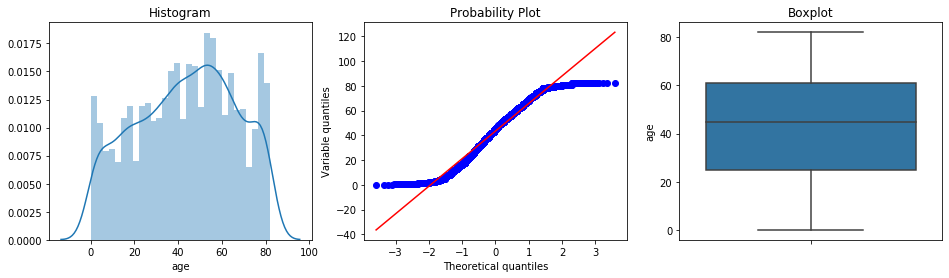

In [338]:
#Compare before and after transformation for age
diagnostic_plots(X_train, 'age')

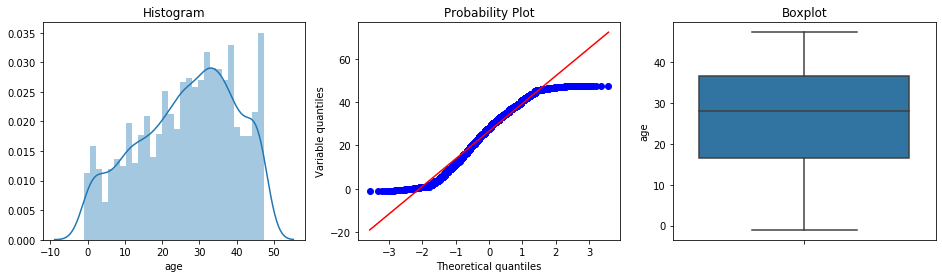

In [339]:
X_train_tf = bct.transform(X_train)
diagnostic_plots(X_train_tf, 'age')

#### We can see from the plot that transformation don't work for age. It makes sense as the orginal distribution of age is not skewed distribution, whereas transformation can only transform skewed distribution to normal distribution.

#### In summary, mathematical tranformation doesn't apply well in our cases.  Thus, we know that logistic regression won't be a great choice for prediction, as we don't have normal distribution for numerical columns.

### 2.6 Feature Scaling

Feature scaling refers to the methods or techniques used to normalize the range of independent variables in our data, or in other words, the methods to set the feature value range within a similar scale. Feature scaling is generally the last step in the data preprocessing pipeline, performed just before training the machine learning algorithms.

Feature magnitude matters because:
1) The regression coefficients of linear models are directly influenced by the scale of the variable.
2) Variables with bigger magnitude / larger value range dominate over those with smaller magnitude / value range
3) Gradient descent converges faster when features are on similar scales
4) Feature scaling helps decrease the time to find support vectors for SVMs
5) Euclidean distances are sensitive to feature magnitude.
6) Some algorithms, like PCA require the features to be centered at 0.

The machine learning models affected by the feature scale are:
1) Linear and Logistic Regression
2) Neural Networks
3) Support Vector Machines
4) KNN
5) K-means clustering
6) Linear Discriminant Analysis (LDA)
7) Principal Component Analysis (PCA)

Feature scaling techniques:

1) Standardizaton - rescales data to have a mean of 0 and a standard deviation of 1. **z=(x-x_mean)/std**
2) Normalization (MinMaxScaling) - rescales the values into a range of [0,1]. **x_scaled=(x-x_min)/(x_max-x_min)**
3) Mean normalisation - rescales data to have a mean of 0 and the values into a range of [-1,1]. **x_scaled=(x-x_mean)/(x_max-x_min)**
4) Scaling to maximun value (MaxAbsScaling) **x_scaled=x/abs(x_max)**
5) Scaling to quantiles and median (RobustScaling) - rescales data to have a median of 0. **x_scaled=x-x_median/(x_quantile(0.75)-x_quatile(0.25))**
6) Normalization to vector unit length - **x_scaled_L1=x/L1(X)** **x_scaled_L2=x/L2(X)**

There isn't a single best feature scaling technique for all ML models. Refer to this reading:
https://towardsdatascience.com/normalization-vs-standardization-quantitative-analysis-a91e8a79cebf

We could consider feature scaling technique as an hyperpamater for models that are sensitive to un-scaled data, as listed above. More reading on whether apply feature scaling to encoded categorical variable:
https://stackoverflow.com/questions/63304223/scaling-of-categorical-variable#:~:text=Encoded%20categorical%20variables%20contain%20values%20on%200%20and,to%20using%20your%20data%20with%20scale-sensitive%20ML%20models.

For now, I'll use stadardization to try it out and comapre the distribution before and after feature scaling.

In [340]:
# standardisation: with the StandardScaler from sklearn

# set up the scaler
scaler = StandardScaler()

# fit the scaler to the train set, it will learn the parameters
scaler.fit(X_train)

# transform train and test sets
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [341]:
# the scaler stores the mean of the features, learned from train set

scaler.mean_

array([4.34388650e+01, 9.93150685e-02, 5.43052838e-02, 1.06255262e+02,
       5.88307241e-01, 4.11448141e-01, 6.59491194e-01, 5.68003914e-01,
       1.60958904e-01, 1.34050881e-01, 1.33561644e-01, 4.89970646e-01,
       1.74168297e-01, 3.69373777e-01, 1.55821918e-01, 6.85176125e-01,
       2.87051370e+01])

In [342]:
# let's transform the returned NumPy arrays to dataframes

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [343]:
# let's have a look at the original training dataset: mean and standard deviation
# I use np.round to reduce the number of decimals to 1.

np.round(X_train.describe(), 1)

,age,hypertension,heart_disease,avg_glucose_level,gender_Female,gender_Male,ever_married_Yes,work_type_Private,work_type_Self-employed,work_type_children,work_type_Govt_job,Residence_type_Rural,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,avg_glucose_level_ranked,bmi_median
count,4088.0,4088.0,4088.0,4088.0,4088.0,4088.0,4088.0,4088.0,4088.0,4088.0,4088.0,4088.0,4088.0,4088.0,4088.0,4088.0,4088.0
mean,43.4,0.1,0.1,106.3,0.6,0.4,0.7,0.6,0.2,0.1,0.1,0.5,0.2,0.4,0.2,0.7,28.7
std,22.7,0.3,0.2,45.3,0.5,0.5,0.5,0.5,0.4,0.3,0.3,0.5,0.4,0.5,0.4,0.8,7.3
min,0.1,0.0,0.0,55.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.3
25%,25.0,0.0,0.0,77.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.7
50%,45.0,0.0,0.0,92.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,28.0
75%,61.0,0.0,0.0,114.2,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,32.8
max,82.0,1.0,1.0,271.7,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,47.5


In [344]:
# let's have a look at the scaled training dataset: mean and standard deviation
# I use np.round to reduce the number of decimals to 1.

np.round(X_train_scaled.describe(), 1)

,age,hypertension,heart_disease,avg_glucose_level,gender_Female,gender_Male,ever_married_Yes,work_type_Private,work_type_Self-employed,work_type_children,work_type_Govt_job,Residence_type_Rural,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,avg_glucose_level_ranked,bmi_median
count,4088.0,4088.0,4088.0,4088.0,4088.0,4088.0,4088.0,4088.0,4088.0,4088.0,4088.0,4088.0,4088.0,4088.0,4088.0,4088.0,4088.0
mean,-0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0
std,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
min,-1.9,-0.3,-0.2,-1.1,-1.2,-0.8,-1.4,-1.1,-0.4,-0.4,-0.4,-1.0,-0.5,-0.8,-0.4,-0.9,-2.5
25%,-0.8,-0.3,-0.2,-0.6,-1.2,-0.8,-1.4,-1.1,-0.4,-0.4,-0.4,-1.0,-0.5,-0.8,-0.4,-0.9,-0.7
50%,0.1,-0.3,-0.2,-0.3,0.8,-0.8,0.7,0.9,-0.4,-0.4,-0.4,-1.0,-0.5,-0.8,-0.4,0.4,-0.1
75%,0.8,-0.3,-0.2,0.2,0.8,1.2,0.7,0.9,-0.4,-0.4,-0.4,1.0,-0.5,1.3,-0.4,0.4,0.6
max,1.7,3.0,4.2,3.7,0.8,1.2,0.7,0.9,2.3,2.5,2.5,1.0,2.2,1.3,2.3,3.1,2.6


As expected, the mean of each variable, which were not centered at zero, is now around zero and the standard deviation is set to 1. Note however, that the minimum and maximum values vary according to how spread the variable was to begin with and can be highly influenced by outliers(we've alredy handeled outliers in our case).

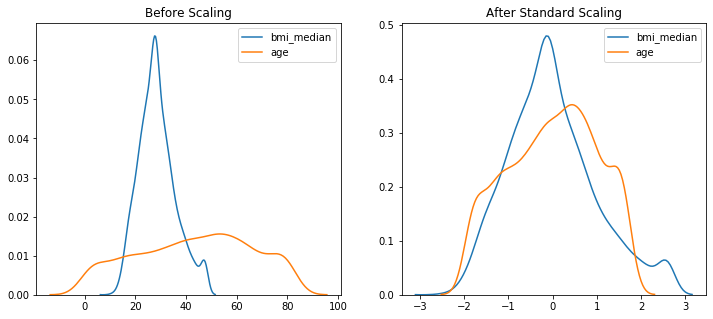

In [345]:
# let's compare the variable distributions before and after scaling

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))

# before scaling
ax1.set_title('Before Scaling')
sns.kdeplot(X_train['bmi_median'], ax=ax1)
sns.kdeplot(X_train['age'], ax=ax1)


# after scaling
ax2.set_title('After Standard Scaling')
sns.kdeplot(X_train_scaled['bmi_median'], ax=ax2)
sns.kdeplot(X_train_scaled['age'], ax=ax2)
plt.show()

Note from the above plots how standardisation centered all the distributions at zero, but it preserved their original distribution. The value range is not identical, but it looks more homogeneous across the variables.

### 2.7 Handling Unbalanced Data

In [346]:
#Check the number of stroke and non-stroke cases, which gives very unbalanced data
df.groupby("stroke").size()

stroke
0    4861
1     249
dtype: int64

In [347]:
stroke = df["stroke"].sum()
print(f"The proportion of stroke cases in the dataset is {round((stroke/df.shape[0]),3)*100}%.")

The proportion of stroke cases in the dataset is 4.9%.


There following are some methods to handle unbalanced data:
1) Oversampling
2) Undersampling
3) Penalize algorithms (cost-sensitive training) - penalized learning algorithms that increase the cost of classification mistakes on the minority class. i.e. penalized-SVM with class_weight='balanced' to penalize mistakes on the minority class by an amount proportional to how under-represented it is.
4) Tree-based algorithms - Decision trees often perform well on imbalanced datasets because their hierarchical structure allows them to learn signals from both classes.

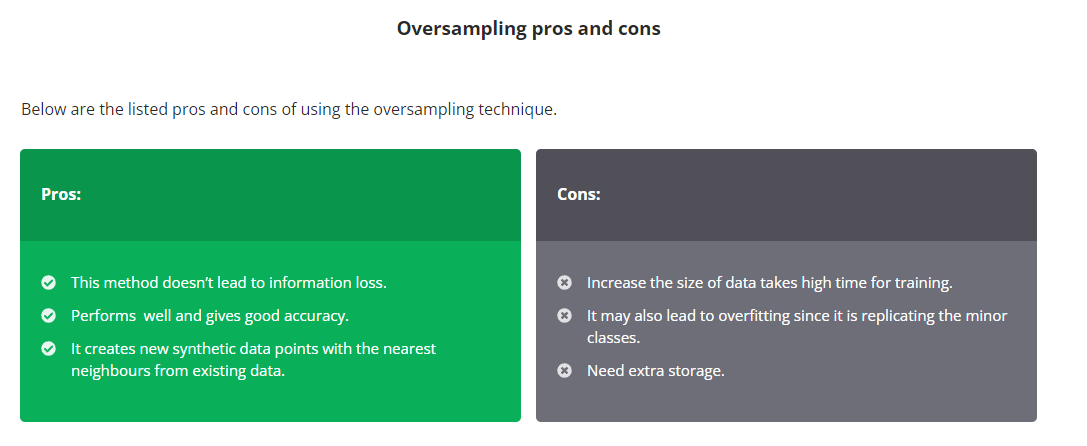

In [348]:
image = Image.open("Oversampling.png")
image

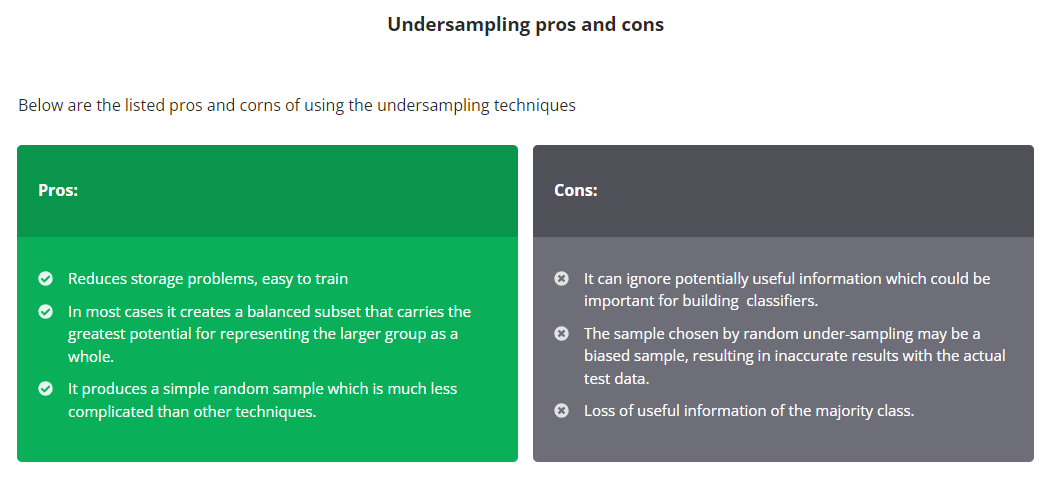

In [349]:
image = Image.open("Undersampling.png")
image

We have about 5000 rows, which is not a huge dataset. Undersampling could ignore useful information and random choosed sample may be biased.

Oversampling could lead to overfitting and how mamy stroke cases we want to oversmaple is difficult to define.

I'd prefer to handle unbalanced class with the other two methods: penalize algorithm and tree-based method.

### Processed Data Final Check and Save

In [350]:
# Review all columns before saving process data
X_train.head()

,age,hypertension,heart_disease,avg_glucose_level,gender_Female,gender_Male,ever_married_Yes,work_type_Private,work_type_Self-employed,work_type_children,work_type_Govt_job,Residence_type_Rural,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,avg_glucose_level_ranked,bmi_median
3029,36.0,0,0,67.29,1,0,1,1,0,0,0,1,1,0,0,0,36.7
2277,34.0,0,0,83.53,1,0,1,1,0,0,0,1,1,0,0,0,47.5
3002,60.0,0,0,65.16,0,1,1,1,0,0,0,1,0,1,0,0,30.8
246,75.0,0,0,78.80,1,0,1,0,1,0,0,1,1,0,0,0,29.3
2825,76.0,0,0,58.65,0,1,1,1,0,0,0,0,0,0,1,0,25.6


In [351]:
X_test.head()

,age,hypertension,heart_disease,avg_glucose_level,gender_Female,gender_Male,ever_married_Yes,work_type_Private,work_type_Self-employed,work_type_children,work_type_Govt_job,Residence_type_Rural,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,avg_glucose_level_ranked,bmi_median
42,82.0,0,1,144.90,0,1,1,1,0,0,0,0,0,0,1,1,26.4
380,4.0,0,0,106.22,0,1,0,0,0,1,0,1,0,0,0,1,16.7
3524,58.0,0,0,79.95,0,1,1,1,0,0,0,0,0,1,0,0,25.9
352,20.0,0,0,96.57,1,0,0,1,0,0,0,1,0,1,0,1,34.1
4927,10.0,0,0,69.84,1,0,0,0,0,1,0,1,0,0,0,0,13.7


In [352]:
# Drop ave_glucose_level from both data, keep ave_glucose_level_ranked
X_train.drop(columns=['avg_glucose_level'],inplace=True)
X_test.drop(columns=['avg_glucose_level'],inplace=True)

# Change bmi_median to bmi for both data
X_train.rename(columns={'bmi_median':'bmi'}, inplace=True)
X_test.rename(columns={'bmi_median':'bmi'}, inplace=True)

In [353]:
# check data type are all numerical
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4088 entries, 3029 to 2732
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   age                             4088 non-null   float64
 1   hypertension                    4088 non-null   int64  
 2   heart_disease                   4088 non-null   int64  
 3   gender_Female                   4088 non-null   int32  
 4   gender_Male                     4088 non-null   int32  
 5   ever_married_Yes                4088 non-null   int32  
 6   work_type_Private               4088 non-null   int32  
 7   work_type_Self-employed         4088 non-null   int32  
 8   work_type_children              4088 non-null   int32  
 9   work_type_Govt_job              4088 non-null   int32  
 10  Residence_type_Rural            4088 non-null   int32  
 11  smoking_status_formerly smoked  4088 non-null   int32  
 12  smoking_status_never smoked    

In [354]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1022 entries, 42 to 2367
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   age                             1022 non-null   float64
 1   hypertension                    1022 non-null   int64  
 2   heart_disease                   1022 non-null   int64  
 3   gender_Female                   1022 non-null   int32  
 4   gender_Male                     1022 non-null   int32  
 5   ever_married_Yes                1022 non-null   int32  
 6   work_type_Private               1022 non-null   int32  
 7   work_type_Self-employed         1022 non-null   int32  
 8   work_type_children              1022 non-null   int32  
 9   work_type_Govt_job              1022 non-null   int32  
 10  Residence_type_Rural            1022 non-null   int32  
 11  smoking_status_formerly smoked  1022 non-null   int32  
 12  smoking_status_never smoked     1

In [357]:
# save processed data
X_train.to_csv('X_train', sep='\t',index=False)
X_test.to_csv('X_test', sep='\t',index=False)

y_train.to_csv('y_train', sep='\t',index=False)
y_test.to_csv('y_test', sep='\t',index=False)

# End of Feature Engineering